In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import math
import random
import statistics
import warnings
warnings.filterwarnings('ignore')
from time import time
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, fbeta_score, roc_curve, auc, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV # Feature selection by RFECV

In [2]:
data = pd.read_csv("OnlineNewsPopularity.csv")
display(data.head())

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [3]:
popularity_raw=data[data.keys()[-1]]
popularity_raw.describe()

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name:  shares, dtype: float64

In [4]:
label_encoder = preprocessing.LabelEncoder()
popular_label = pd.Series(label_encoder.fit_transform(popularity_raw>=1400))
features_raw = data.drop([data.keys()[0],data.keys()[1],data.keys()[-1]], axis=1)
features_raw.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364


In [5]:
columns_day=features_raw.columns.values[29:36]
unpopular = data[data[' shares']<1400]
popular = data[data[' shares']>=1400]
unpopular_days = unpopular[columns_day].sum().values
popular_days = popular[columns_day].sum().values

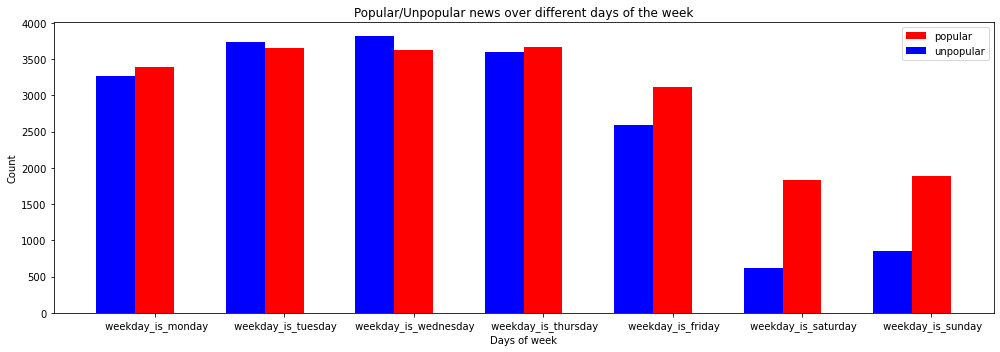

In [6]:
fig = plt.figure(figsize=(14,5))
plt.title("Popular/Unpopular news over different days of the week")
plt.bar(np.arange(len(columns_day)), popular_days,width=0.3,color='r',label = "popular")
plt.bar(np.arange(len(columns_day))-0.3, unpopular_days,width=0.3,color='b',label = "unpopular")
plt.xticks(np.arange(len(columns_day)),columns_day)
plt.ylabel("Count")
plt.xlabel("Days of week")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

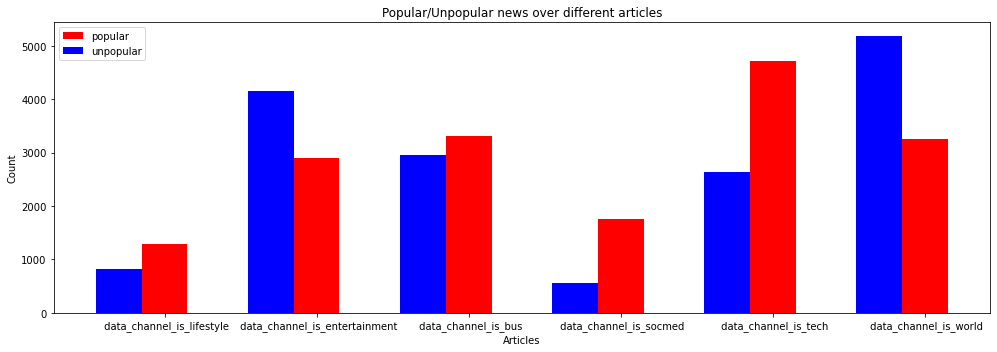

In [7]:
columns_chan = features_raw.columns.values[11:17]
unpopular_chan = unpopular[columns_chan].sum().values
popular_chan = popular[columns_chan].sum().values
fig = plt.figure(figsize=(14,5))
plt.title("Popular/Unpopular news over different articles")
plt.bar(np.arange(len(columns_chan)), popular_chan,width=0.3,color='r',label = "popular")
plt.bar(np.arange(len(columns_chan)) -0.3, unpopular_chan,width=0.3,color='b',label = "unpopular")
plt.xticks(np.arange(len(columns_chan)),columns_chan)
plt.ylabel("Count")
plt.xlabel("Articles")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'PCA on 2 Dimensions')

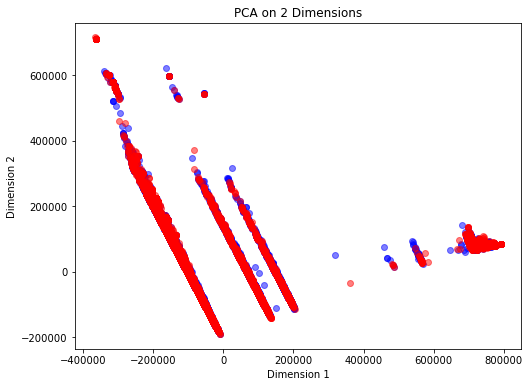

In [8]:
pca = PCA(n_components=2).fit(features_raw)
pca_2d_features = pca.transform(features_raw)
pca_2d_features = pd.DataFrame(pca_2d_features,columns=['Dimension 1', 'Dimension 2'])
pca_2d_features_popular = pca_2d_features[data[' shares']>=1400]
pca_2d_features_unpopular = pca_2d_features[data[' shares']<1400]
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x=pca_2d_features_popular.loc[:,'Dimension 1'], y=pca_2d_features_popular.loc[:,'Dimension 2'],c='b',alpha = 0.5)
ax.scatter(x=pca_2d_features_unpopular.loc[:,'Dimension 1'], y=pca_2d_features_unpopular.loc[:,'Dimension 2'],c='r',alpha = 0.5)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title("PCA on 2 Dimensions")

In [9]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time

    results['train_time'] = end-start
        
    # Get predictions on the first 4000 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:4000])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute accuracy on the first 4000 training samples
    results['acc_train'] = accuracy_score(y_train[:4000],predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 4000 training samples
    results['f_train'] = fbeta_score(y_train[:4000],predictions_train,beta=1)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=1)
    
    # Compute AUC on the the first 4000 training samples
    results['auc_train'] = roc_auc_score(y_train[:4000],predictions_train)
        
    # Compute AUC on the test set
    results['auc_test'] = roc_auc_score(y_test,predictions_test)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    print("{} with accuracy {}, F1 {} and AUC {}.".format(learner.__class__.__name__,results['acc_test'],results['f_test'], results['auc_test']))
    # Return the results
    return results

In [10]:
def evaluate(results):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 4, figsize = (16,7))

    # Constants
    bar_width = 0.2
    colors = ['#A00000','#00A0A0','#00A000',"#0A0A0A"]
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'auc_train','pred_time', 'acc_test',\
                                    'f_test', 'auc_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//4, j%4].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//4, j%4].set_xticks([0.5, 2.0, 3.5])
                ax[j//4, j%4].set_xticklabels(["1%", "10%", "100%"])
                ax[j//4, j%4].set_xlim(auto=True)
    
    # Add labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[0, 3].set_ylabel("AUC")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    ax[1, 3].set_ylabel("AUC")
    ax[1, 0].set_xlabel("Training Set Size")
    ax[1, 1].set_xlabel("Training Set Size")
    ax[1, 2].set_xlabel("Training Set Size")
    ax[1, 3].set_xlabel("Training Set Size")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[0, 3].set_title("AUC on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    ax[1, 3].set_title("AUC on Training Subset")
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[0, 3].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))
    ax[1, 3].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches,  bbox_to_anchor = (-1.4, 2.54),loc = 'best', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features_raw, popular_label, test_size = 0.1, random_state = 42)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 35679 samples.
Testing set has 3965 samples.


AdaBoostClassifier trained on 356 samples.
AdaBoostClassifier with accuracy 0.6005044136191677, F1 0.6406533575317604 and AUC 0.5964792346022463.
AdaBoostClassifier trained on 3567 samples.
AdaBoostClassifier with accuracy 0.6395964691046658, F1 0.6633686690223792 and AUC 0.6376699377759822.
AdaBoostClassifier trained on 35679 samples.
AdaBoostClassifier with accuracy 0.666078184110971, F1 0.689784442361762 and AUC 0.6639315183853889.
LogisticRegression trained on 356 samples.
LogisticRegression with accuracy 0.5636822194199244, F1 0.6422663358147229 and AUC 0.554302811991041.
LogisticRegression trained on 3567 samples.
LogisticRegression with accuracy 0.5883984867591425, F1 0.6243093922651934 and AUC 0.5851321119083579.
LogisticRegression trained on 35679 samples.
LogisticRegression with accuracy 0.5891551071878941, F1 0.6422139248846915 and AUC 0.5833186686845223.
XGBClassifier trained on 356 samples.
XGBClassifier with accuracy 0.6045397225725094, F1 0.6512455516014235 and AUC 0.599

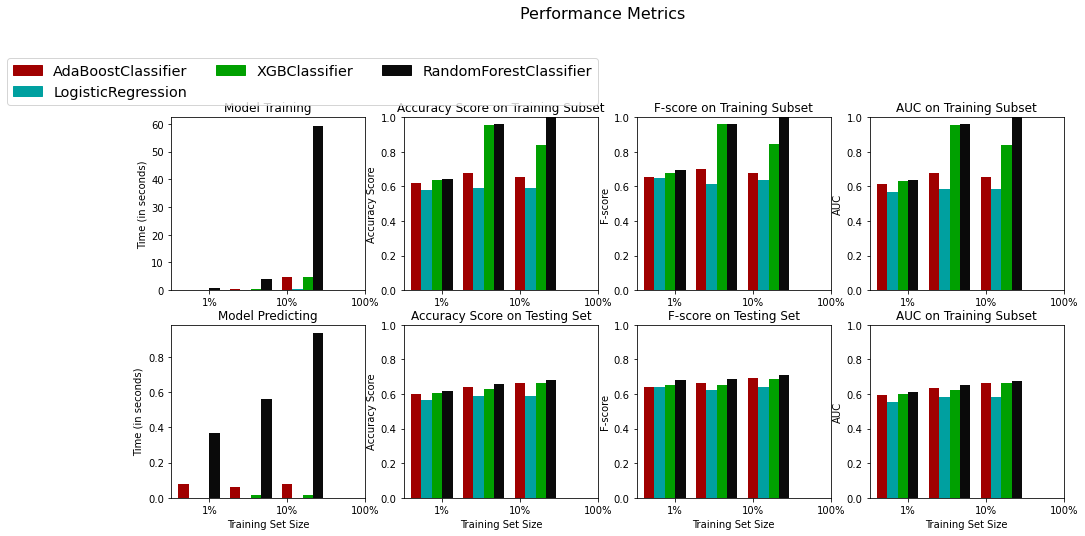

In [13]:
clf_A = AdaBoostClassifier(random_state=0)
clf_B = LogisticRegression(random_state=0,C=1.0)
clf_C = xgboost.XGBClassifier(eval_metric='mlogloss')
clf_D = RandomForestClassifier(random_state=0, n_estimators=500)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(X_train.shape[0]*0.01)
samples_10 = int(X_train.shape[0]*0.1)
samples_100 = X_train.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C,clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)
# Run metrics visualization for the three supervised learning models chosen
evaluate(results)

In [14]:
df = features_raw
df['Popularity'] = popular_label
df.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popularity
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,0
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,0
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,0
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,0


In [15]:
pearson_corr = df.corr(method="pearson")['Popularity'][:-1]
kendall_corr = df.corr(method="kendall")['Popularity'][:-1]
spearman_corr = df.corr(method="spearman")["Popularity"][:-1]

In [16]:
nrows,ncols = df.shape
corr_selection = []
for i in range(ncols-2):
    if pearson_corr[i] > 0 and spearman_corr[i] > 0 and kendall_corr[i] > 0:
        corr_selection.append(df.columns[i+1])
corr_selection

[' n_unique_tokens',
 ' n_non_stop_unique_tokens',
 ' num_self_hrefs',
 ' num_imgs',
 ' num_videos',
 ' average_token_length',
 ' data_channel_is_lifestyle',
 ' data_channel_is_entertainment',
 ' data_channel_is_tech',
 ' data_channel_is_world',
 ' kw_max_min',
 ' kw_avg_min',
 ' kw_min_max',
 ' kw_max_max',
 ' kw_min_avg',
 ' kw_max_avg',
 ' kw_avg_avg',
 ' self_reference_min_shares',
 ' self_reference_max_shares',
 ' self_reference_avg_sharess',
 ' weekday_is_monday',
 ' weekday_is_saturday',
 ' weekday_is_sunday',
 ' is_weekend',
 ' LDA_00',
 ' LDA_01',
 ' LDA_04',
 ' global_subjectivity',
 ' global_sentiment_polarity',
 ' global_rate_positive_words',
 ' global_rate_negative_words',
 ' rate_negative_words',
 ' min_positive_polarity',
 ' avg_negative_polarity',
 ' title_subjectivity',
 ' title_sentiment_polarity',
 ' abs_title_subjectivity']

In [17]:
features_corr = data[corr_selection]
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(features_corr, popular_label, test_size = 0.1, random_state = 42)
print("Training set has {} samples.".format(X_train_corr.shape[0]))
print("Testing set has {} samples.".format(X_test_corr.shape[0]))

Training set has 35679 samples.
Testing set has 3965 samples.


AdaBoostClassifier trained on 356 samples.
AdaBoostClassifier with accuracy 0.594703656998739, F1 0.6420138115393184 and AUC 0.5896679515449399.
AdaBoostClassifier trained on 3567 samples.
AdaBoostClassifier with accuracy 0.6491803278688525, F1 0.6741625673459827 and AUC 0.6469812246588493.
AdaBoostClassifier trained on 35679 samples.
AdaBoostClassifier with accuracy 0.6668348045397225, F1 0.6948486948486948 and AUC 0.6639392970251932.
LogisticRegression trained on 356 samples.
LogisticRegression with accuracy 0.5775535939470365, F1 0.6580934884670342 and AUC 0.5674318807934926.
LogisticRegression trained on 3567 samples.
LogisticRegression with accuracy 0.5987389659520808, F1 0.6351754184819995 and AUC 0.5952879550440526.
LogisticRegression trained on 35679 samples.
LogisticRegression with accuracy 0.5889029003783102, F1 0.6380994671403196 and AUC 0.5836688349943917.
XGBClassifier trained on 356 samples.
XGBClassifier with accuracy 0.6040353089533418, F1 0.645117540687161 and AUC 0.59

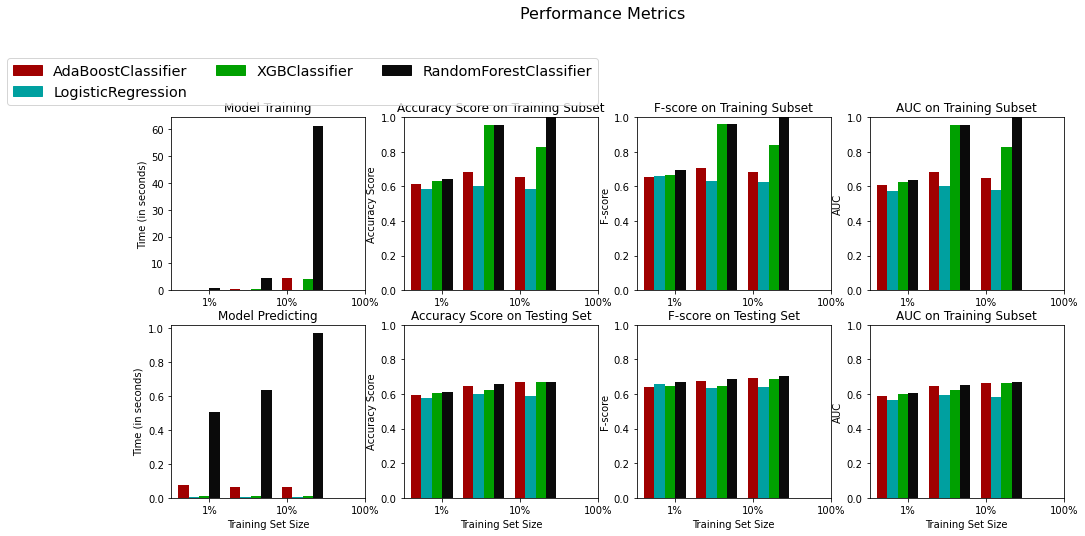

In [18]:
clf_A = AdaBoostClassifier(random_state=0)
clf_B = LogisticRegression(random_state=0,C=1.0)
clf_C = xgboost.XGBClassifier(eval_metric='mlogloss')
clf_D = RandomForestClassifier(random_state=0, n_estimators=500)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(X_train_corr.shape[0]*0.01)
samples_10 = int(X_train_corr.shape[0]*0.1)
samples_100 = X_train_corr.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C,clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train_corr, y_train_corr, X_test_corr, y_test_corr)
# Run metrics visualization for the three supervised learning models chosen
evaluate(results)

In [30]:
scaler = MinMaxScaler()
numerical = [' n_tokens_title', ' n_tokens_content', ' num_hrefs', ' num_self_hrefs', ' num_imgs',' num_videos',' average_token_length',' num_keywords',' self_reference_min_shares',' self_reference_max_shares',' self_reference_avg_sharess']
features_raw[numerical] = scaler.fit_transform(data[numerical])
features_raw.drop(columns='Popularity',axis=1,inplace=True)
display(features_raw.head())

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,0.476190,0.025844,0.663594,1.0,0.815385,0.013158,0.017241,0.007812,0.0,0.582024,...,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500
1,0.333333,0.030092,0.604743,1.0,0.791946,0.009868,0.008621,0.007812,0.0,0.611043,...,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000
2,0.333333,0.024900,0.575130,1.0,0.663866,0.009868,0.008621,0.007812,0.0,0.546334,...,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000
3,0.333333,0.062662,0.503788,1.0,0.665635,0.029605,0.000000,0.007812,0.0,0.547768,...,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000
4,0.523810,0.126505,0.415646,1.0,0.540890,0.062500,0.163793,0.156250,0.0,0.582331,...,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364


In [31]:
features_raw

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,0.476190,0.025844,0.663594,1.0,0.815385,0.013158,0.017241,0.007812,0.000000,0.582024,...,0.378636,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500
1,0.333333,0.030092,0.604743,1.0,0.791946,0.009868,0.008621,0.007812,0.000000,0.611043,...,0.286915,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000
2,0.333333,0.024900,0.575130,1.0,0.663866,0.009868,0.008621,0.007812,0.000000,0.546334,...,0.495833,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000
3,0.333333,0.062662,0.503788,1.0,0.665635,0.029605,0.000000,0.007812,0.000000,0.547768,...,0.385965,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000
4,0.523810,0.126505,0.415646,1.0,0.540890,0.062500,0.163793,0.156250,0.000000,0.582331,...,0.411127,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,0.428571,0.040831,0.529052,1.0,0.684783,0.029605,0.060345,0.007812,0.010989,0.562470,...,0.333791,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000
39640,0.476190,0.038707,0.696296,1.0,0.885057,0.029605,0.060345,0.023438,0.527473,0.547842,...,0.374825,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000
39641,0.380952,0.052160,0.516355,1.0,0.644128,0.078947,0.008621,0.093750,0.010989,0.631338,...,0.307273,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364
39642,0.190476,0.080481,0.539493,1.0,0.692661,0.032895,0.008621,0.007812,0.000000,0.618672,...,0.236851,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000


In [32]:
estimator_Ada = AdaBoostClassifier(random_state=0)
selector_Ada = RFECV(estimator_Ada, step=1, cv=5)
selector_Ada = selector_Ada.fit(features_raw, popular_label)
selector_Ada.ranking_

array([41, 16, 11, 21,  1,  7,  1,  1,  1, 30,  1, 25,  1, 32,  1, 10, 37,
        1, 17,  1,  1,  1, 22,  1,  1,  1,  1,  1,  8, 40, 33, 35, 31,  2,
        3, 18,  4,  9,  5,  6, 12, 28,  1,  1, 36, 34, 19, 29, 20, 13, 23,
       24, 26, 27, 14, 15, 38, 39])

In [33]:
estimator_LR = LogisticRegression(random_state=0)
selector_LR = RFECV(estimator_LR, step=1, cv=5)
selector_LR = selector_LR.fit(features_raw, popular_label)
selector_LR.ranking_

array([28, 33, 19,  9, 23, 34, 41, 31, 47, 29, 17, 26,  2, 35,  8,  1,  1,
        1,  3,  1,  4,  1,  1,  1,  1,  1, 43, 36, 38, 20, 14, 13, 18, 30,
        7, 10,  1, 11, 12,  5, 40,  6, 27, 24, 44, 46, 22, 16, 45, 32, 21,
       37, 39, 42, 48, 15, 49, 25])

In [34]:
estimator_XGB = xgboost.XGBClassifier(eval_metric='mlogloss')
selector_XGB = RFECV(estimator_XGB, step=1, cv=5)
selector_XGB = selector_XGB.fit(features_raw, popular_label)
selector_XGB.ranking_

array([44, 22, 11, 55, 17, 19, 37, 12, 28, 35, 51, 21,  1,  8,  1,  3,  1,
       14, 33, 26, 15,  2, 27, 16,  7,  4,  9, 24,  6, 53, 42, 36, 48, 10,
        5, 50,  1, 23, 20, 18, 31, 32, 30, 25, 40, 41, 45, 29, 39, 13, 54,
       38, 47, 49, 52, 34, 43, 46])

In [35]:
estimator_RF = RandomForestClassifier(n_estimators=20,random_state=0,max_depth=10)
selector_RF = RFECV(estimator_RF, step=1, cv=5)
selector_RF = selector_RF.fit(features_raw, popular_label)
selector_RF.ranking_

array([1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

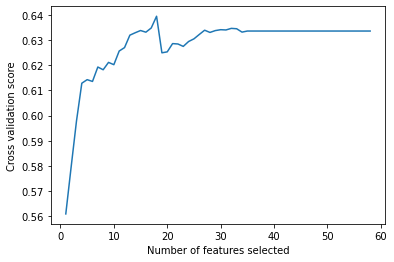

18
[' n_non_stop_unique_tokens' ' num_self_hrefs' ' num_imgs' ' num_videos'
 ' num_keywords' ' data_channel_is_entertainment'
 ' data_channel_is_socmed' ' kw_min_min' ' kw_avg_min' ' kw_min_max'
 ' kw_max_max' ' kw_min_avg' ' kw_max_avg' ' kw_avg_avg'
 ' self_reference_min_shares' ' self_reference_max_shares'
 ' global_subjectivity' ' global_sentiment_polarity']


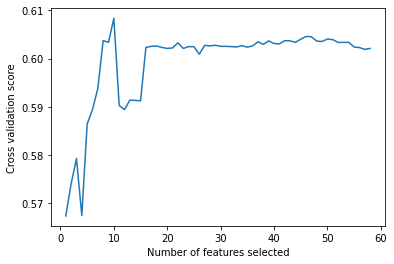

10
[' data_channel_is_tech' ' data_channel_is_world' ' kw_min_min'
 ' kw_avg_min' ' kw_max_max' ' kw_avg_max' ' kw_min_avg' ' kw_max_avg'
 ' kw_avg_avg' ' is_weekend']


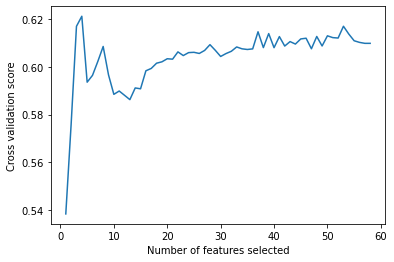

4
[' data_channel_is_entertainment' ' data_channel_is_socmed'
 ' data_channel_is_world' ' is_weekend']


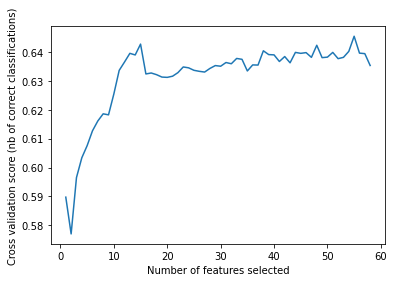

55
[' n_tokens_title' ' n_tokens_content' ' n_unique_tokens'
 ' n_non_stop_unique_tokens' ' num_hrefs' ' num_self_hrefs' ' num_imgs'
 ' num_videos' ' average_token_length' ' num_keywords'
 ' data_channel_is_lifestyle' ' data_channel_is_entertainment'
 ' data_channel_is_bus' ' data_channel_is_socmed' ' data_channel_is_tech'
 ' data_channel_is_world' ' kw_min_min' ' kw_max_min' ' kw_avg_min'
 ' kw_min_max' ' kw_max_max' ' kw_avg_max' ' kw_min_avg' ' kw_max_avg'
 ' kw_avg_avg' ' self_reference_min_shares' ' self_reference_max_shares'
 ' self_reference_avg_sharess' ' weekday_is_tuesday'
 ' weekday_is_wednesday' ' weekday_is_friday' ' weekday_is_saturday'
 ' weekday_is_sunday' ' is_weekend' ' LDA_00' ' LDA_01' ' LDA_02'
 ' LDA_03' ' LDA_04' ' global_subjectivity' ' global_sentiment_polarity'
 ' global_rate_positive_words' ' global_rate_negative_words'
 ' rate_positive_words' ' rate_negative_words' ' avg_positive_polarity'
 ' min_positive_polarity' ' max_positive_polarity'
 ' avg_negative_po

In [38]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(selector_Ada.grid_scores_) + 1), selector_Ada.grid_scores_)
plt.savefig('RFE_ADA.pdf')
plt.show()

print(features_raw.columns.values[selector_Ada.ranking_==1].shape[0])
print(features_raw.columns.values[selector_Ada.ranking_==1])
features_ADA = features_raw[features_raw.columns.values[selector_Ada.ranking_==1]]

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(selector_LR.grid_scores_) + 1), selector_LR.grid_scores_)
plt.savefig('RFE_LR.pdf')
plt.show()

print(features_raw.columns.values[selector_LR.ranking_==1].shape[0])
print(features_raw.columns.values[selector_LR.ranking_==1])
features_LR = features_raw[features_raw.columns.values[selector_LR.ranking_==1]]


plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(selector_XGB.grid_scores_) + 1), selector_XGB.grid_scores_)
plt.savefig('RFE_XGB.pdf')
plt.show()

print(features_raw.columns.values[selector_XGB.ranking_==1].shape[0])
print(features_raw.columns.values[selector_XGB.ranking_==1])
features_XGB = features_raw[features_raw.columns.values[selector_XGB.ranking_==1]]

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector_RF.grid_scores_) + 1), selector_RF.grid_scores_)
plt.savefig('RFE_RF.pdf')
plt.show()

print(features_raw.columns.values[selector_RF.ranking_==1].shape[0])
print(features_raw.columns.values[selector_RF.ranking_==1])
features_RF = features_raw[features_raw.columns.values[selector_RF.ranking_==1]]

In [39]:
X_train_ADA, X_test_ADA, y_train_ADA, y_test_ADA = train_test_split(features_ADA, popular_label, test_size = 0.1, random_state = 42)
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(features_LR, popular_label, test_size = 0.1, random_state = 42)
X_train_XGB, X_test_XGB, y_train_XGB, y_test_XGB = train_test_split(features_XGB, popular_label, test_size = 0.1, random_state = 42)
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(features_RF, popular_label, test_size = 0.1, random_state = 42)
print("Training set of ADABooster has {} samples.".format(X_train_ADA.shape[0]))
print("Testing set of ADABooster has {} samples.".format(X_test_ADA.shape[0]))
print("Training set of LR has {} samples.".format(X_train_LR.shape[0]))
print("Testing set of LR has {} samples.".format(X_test_LR.shape[0]))
print("Training set of XGB has {} samples.".format(X_train_XGB.shape[0]))
print("Testing set of XGB has {} samples.".format(X_test_XGB.shape[0]))
print("Training set of RF has {} samples.".format(X_train_RF.shape[0]))
print("Testing set of RF has {} samples.".format(X_test_RF.shape[0]))

Training set of ADABooster has 35679 samples.
Testing set of ADABooster has 3965 samples.
Training set of LR has 35679 samples.
Testing set of LR has 3965 samples.
Training set of XGB has 35679 samples.
Testing set of XGB has 3965 samples.
Training set of RF has 35679 samples.
Testing set of RF has 3965 samples.


AdaBoostClassifier trained on 356 samples.
AdaBoostClassifier with accuracy 0.5899117276166457, F1 0.6223873664653972 and AUC 0.5871165576891981.
AdaBoostClassifier trained on 3567 samples.
AdaBoostClassifier with accuracy 0.6398486759142497, F1 0.6654170571696345 and AUC 0.6376397158475631.
AdaBoostClassifier trained on 35679 samples.
AdaBoostClassifier with accuracy 0.6554854981084489, F1 0.684526558891455 and AUC 0.6525507307585781.
LogisticRegression trained on 356 samples.
LogisticRegression with accuracy 0.5735182849936948, F1 0.6566497461928934 and AUC 0.5630670437139154.
LogisticRegression trained on 3567 samples.
LogisticRegression with accuracy 0.610844892812106, F1 0.6463442585377035 and AUC 0.6073980220321684.
LogisticRegression trained on 35679 samples.
LogisticRegression with accuracy 0.6136191677175283, F1 0.6607617360496014 and AUC 0.6082961361328276.
XGBClassifier trained on 356 samples.
XGBClassifier with accuracy 0.6287515762925598, F1 0.6872078198045048 and AUC 0.62

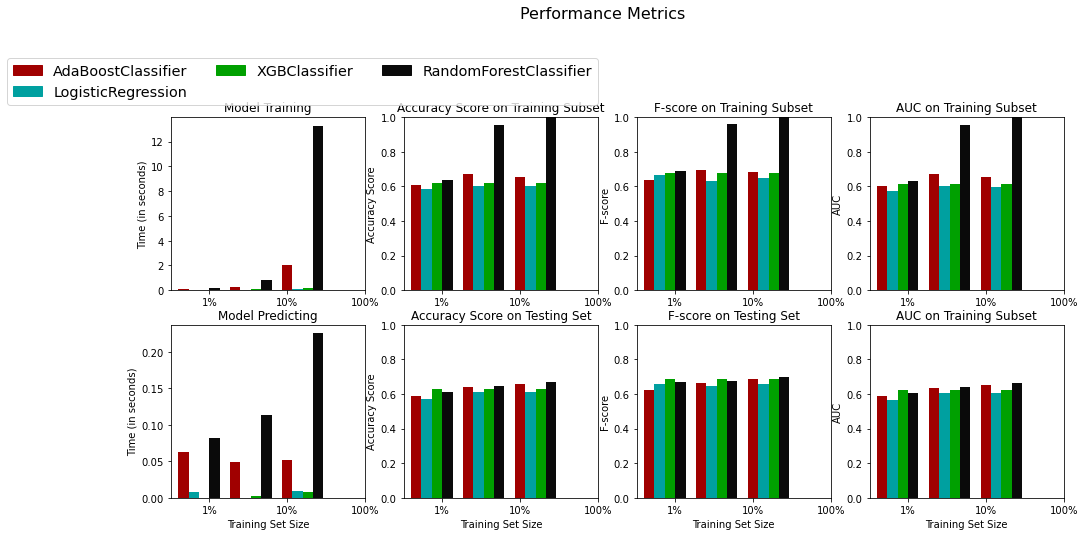

In [40]:
# Initialize the three models
clf_A = AdaBoostClassifier(random_state=0)
clf_B = LogisticRegression(random_state=0,C=1.0)
clf_C = xgboost.XGBClassifier(eval_metric='mlogloss')
clf_D = RandomForestClassifier(random_state=0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(X_train_ADA.shape[0]*0.01)
samples_10 = int(X_train_ADA.shape[0]*0.1)
samples_100 = X_train_ADA.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B,clf_C,clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        if clf == clf_A:
            results[clf_name][i] = \
            train_predict(clf, samples, X_train_ADA, y_train_ADA, X_test_ADA, y_test_ADA)
        elif clf == clf_B:
            results[clf_name][i] = \
            train_predict(clf, samples, X_train_LR, y_train_LR, X_test_LR, y_test_LR)
        elif clf == clf_C:
            results[clf_name][i] = \
            train_predict(clf, samples, X_train_XGB, y_train_XGB, X_test_XGB, y_test_XGB)
        else:
            results[clf_name][i] = \
            train_predict(clf, samples, X_train_RF, y_train_RF, X_test_RF, y_test_RF)
# Run metrics visualization for the three supervised learning models chosen
evaluate(results)

In [41]:
def gridsearch(clf,parameters,X_train, y_train, X_test, y_test):
    scorer = make_scorer(roc_auc_score)
    grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters
    grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
    best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
    print(clf.__class__.__name__)
    print("Unoptimized model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions,beta=1)))
    print("AUC on testing data: {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nOptimized Model\n------")
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta=1)))
    print("Final AUC on the testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions)))
    print(best_clf)

In [42]:
parameters_LR = {"penalty": ['l1','l2'],
              "C": [0.1,0.5,1.,2.,2.5,5]}
parameters_ADA = {"n_estimators": [100,200,300,400],
              "learning_rate": [0.1,0.5,1]}
parameters_XGB = {'max_depth': range (2, 10, 1),'n_estimators': range(100,200,300),'learning_rate': [0.1, 0.01, 0.05]}
parameters_RF = {"n_estimators": [10,20,50,100,250,500]}

In [43]:
# Grid search for Adaboost
gridsearch(clf_A,parameters_ADA,X_train_ADA, y_train_ADA, X_test_ADA, y_test_ADA)

AdaBoostClassifier
Unoptimized model
------
Accuracy score on testing data: 0.6555
F-score on testing data: 0.6845
AUC on testing data: 0.6526

Optimized Model
------
Final accuracy score on the testing data: 0.6578
Final F-score on the testing data: 0.6874
Final AUC on the testing data: 0.6547
AdaBoostClassifier(learning_rate=0.5, n_estimators=200, random_state=0)


In [44]:
# Grid search for logistic regression
gridsearch(clf_B,parameters_LR,X_train_LR, y_train_LR, X_test_LR, y_test_LR)

LogisticRegression
Unoptimized model
------
Accuracy score on testing data: 0.6136
F-score on testing data: 0.6608
AUC on testing data: 0.6083

Optimized Model
------
Final accuracy score on the testing data: 0.6136
Final F-score on the testing data: 0.6608
Final AUC on the testing data: 0.6083
LogisticRegression(C=0.5, random_state=0)


In [45]:
# Grid search for Gaussian NB
gridsearch(clf_C,parameters_XGB,X_train_XGB, y_train_XGB, X_test_XGB, y_test_XGB)

XGBClassifier
Unoptimized model
------
Accuracy score on testing data: 0.6288
F-score on testing data: 0.6872
AUC on testing data: 0.6211

Optimized Model
------
Final accuracy score on the testing data: 0.6288
Final F-score on the testing data: 0.6872
Final AUC on the testing data: 0.6211
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [46]:
gridsearch(clf_D,parameters_RF,X_train_RF, y_train_RF, X_test_RF, y_test_RF)

RandomForestClassifier
Unoptimized model
------
Accuracy score on testing data: 0.6689
F-score on testing data: 0.6957
AUC on testing data: 0.6661

Optimized Model
------
Final accuracy score on the testing data: 0.6792
Final F-score on the testing data: 0.7089
Final AUC on the testing data: 0.6758
RandomForestClassifier(n_estimators=500, random_state=0)


AdaBoostClassifier trained on 356 samples.
AdaBoostClassifier with accuracy 0.5790668348045397, F1 0.6105017502917153 and AUC 0.5765043251787685.
AdaBoostClassifier trained on 3567 samples.
AdaBoostClassifier with accuracy 0.6436317780580075, F1 0.6693189796395974 and AUC 0.6413702749863938.
AdaBoostClassifier trained on 35679 samples.
AdaBoostClassifier with accuracy 0.6577553593947036, F1 0.6873992167703293 and AUC 0.6546906218168148.
LogisticRegression trained on 356 samples.
LogisticRegression with accuracy 0.5735182849936948, F1 0.6566497461928934 and AUC 0.5630670437139154.
LogisticRegression trained on 3567 samples.
LogisticRegression with accuracy 0.610844892812106, F1 0.6463442585377035 and AUC 0.6073980220321684.
LogisticRegression trained on 35679 samples.
LogisticRegression with accuracy 0.6136191677175283, F1 0.6607617360496014 and AUC 0.6082961361328276.
[21:52:43] WARNING: ..\src\learner.cc:576: 
Parameters: { "val_metric" } might not be used.

  This could be a false al

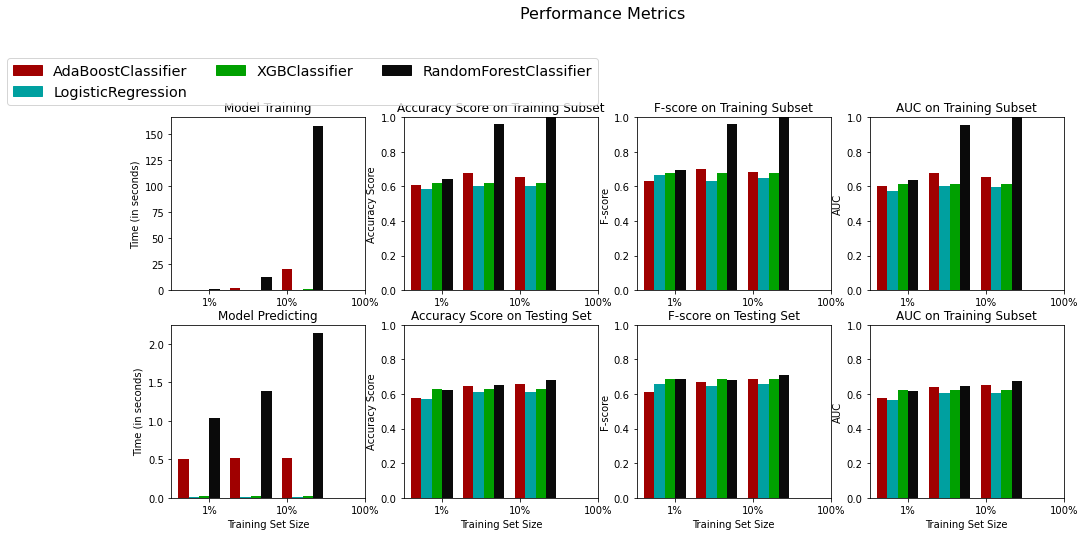

In [47]:
clf_A = AdaBoostClassifier(learning_rate=0.5, n_estimators=200, random_state=0)
clf_B = LogisticRegression(random_state=0, C=0.5)
clf_C = xgboost.XGBClassifier(base_score=0.5, booster='gbtree',learning_rate=0.1, n_estimators=100,random_state=0,val_metric='mlogloss')
clf_D = RandomForestClassifier(random_state=0, n_estimators=500)
results = {}
for clf in [clf_A, clf_B,clf_C,clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        if clf == clf_A:
            results[clf_name][i] = \
            train_predict(clf, samples, X_train_ADA, y_train_ADA, X_test_ADA, y_test_ADA)
        elif clf == clf_B:
            results[clf_name][i] = \
            train_predict(clf, samples, X_train_LR, y_train_LR, X_test_LR, y_test_LR)
        elif clf == clf_C:
            results[clf_name][i] = \
            train_predict(clf, samples, X_train_XGB, y_train_XGB, X_test_XGB, y_test_XGB)
        else:
            results[clf_name][i] = \
            train_predict(clf, samples, X_train_RF, y_train_RF, X_test_RF, y_test_RF)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results)

In [48]:
def init_population(p_size, c, top_num):
    population = []
    for i in range(p_size):
        individual = [0]*c
        j = 0
        while(j<top_num):
            p = random.uniform(0,1)
            pos = random.randrange(c)
            if p >= 0.5 and individual[pos] == 0:
                individual[pos] = 1
                j = j+1
        if sum(individual) == 0:
            pos = random.randrange(c)
            individual[pos] = 1
        population.append(individual)
    #print("Population is ", population)
    #print(population)
    return population

In [49]:
def calculate_fitness(features, target):
    model = MLPClassifier()
    scores = cross_val_score(model, features, target, scoring='f1_macro',n_jobs=-1,cv=10)
    #print(scores)
    print(scores.mean())
    return scores.mean()

In [50]:
def get_fitness(population, data, target):
    fit_values = []
    for individual in population:
        #print("Individual is ",individual)
        df = data
        i=0
        for column in data:
            if individual[i] == 0:
                df = df.drop(column, axis=1)
            i = i+1
        features = df
        #print(features)
        individual_fitness = calculate_fitness(features, target)
        fit_values.append(individual_fitness)
    return fit_values

In [51]:
def select_parents(population, fit_values):
    parents = []
    total = sum(fit_values)
    #print(total)
    norm_fit_values = [x/total for x in fit_values]
    #print(norm_fit_values)
    cumulative_fitness = []
    i = 0
    for norm in norm_fit_values:
        i += norm
        cumulative_fitness.append(norm)
    #print(cumulative_fitness)
    p_size = len(population)
    #print(p_size)
    for count in range(p_size):
        random_num = random.uniform(0,1)
        individual_num = 0
        for score in cumulative_fitness:
            if random_num <= score:
                parents.append(population[individual_num])
                break
            individual_num+=1
    #print(parents)
    return parents

In [52]:
def crossover(parents, probability):
    random.shuffle(parents)
    num_of_pairs = round(len(parents)*probability/2)
    #print(num_of_pairs)
    chromosome_len = len(parents[0])
    crossover_population = []
    for i in range(num_of_pairs):
        length = len(parents)
        parent1_index = random.randrange(length)
        parent2_index = random.randrange(length)
        while(parent1_index == parent2_index):
            parent2_index = random.randrange(length)
        start = random.randrange(chromosome_len)
        end = random.randrange(chromosome_len)
        if start > end:
            start,end = end, start
        parent1 = parents[parent1_index]
        parent2 = parents[parent2_index]
        child1 =  parent1[0:start] 
        child1.extend(parent2[start:end])
        child1.extend(parent1[end:])
        child2 =  parent2[0:start]
        child2.extend(parent1[start:end])
        child2.extend(parent2[end:])
        parents.remove(parent1)
        parents.remove(parent2)
        crossover_population.append(child1)
        crossover_population.append(child2)
    if (len(parents) > 0):
        for remaining_parents in parents:
            crossover_population.append(remaining_parents)
    return crossover_population

In [53]:
def mutation(crossover_population):
    for individual in crossover_population:
        i_1 = random.randrange(len(individual))
        i_2 = random.randrange(len(individual))
        while (i_2 == i_1) and individual[i_1] != individual[i_2]:
            i_2 = random.randrange(len(individual))
        t = individual[i_1]
        individual[i_1] = individual[i_2]
        individual[i_2] = t
    return crossover_population

In [57]:
def genetic_algo(data,features,target,population_size,tol_level,top_number):
    c = data.shape[1]
    population = init_population(population_size, c, top_number)
    fitness_values = get_fitness(population, data, target)
    parents = select_parents(population, fitness_values)
    #print(parents)
    crossover_population = crossover(parents, 0.8)
    population = crossover_population
    p = random.uniform(0,1)
    if (p <= 0.001):
        mutated_population = mutation(crossover_population)
        population = mutated_population
    fitness_values = get_fitness(population, data, target)
    var_of_population = np.var(fitness_values)
    #print("Variance is ", var_of_population)
    count_of_gen = 1
    while(var_of_population > tol_level):
        print('Generations: ', count_of_gen)
        parents = select_parents(population, fitness_values)
        crossover_population = crossover(parents, 0.8)
        population = crossover_population
        p = random.uniform(0,1)
        if (p <= 0.1):
            mutated_population = mutation(crossover_population)
            population = mutated_population
        fitness_values = get_fitness(population, data, target)
        var_of_population = np.var(fitness_values)
        #print("Variance is ", var_of_population)
        count_of_gen+=1
    best_features = []
    best_f1_score = 0
    optimal_fitness = sum(fitness_values)/ len(fitness_values)
    print("Average fitness is: ", optimal_fitness)
    for i,fit_value in enumerate(fitness_values):
        err = abs((fit_value - optimal_fitness)/optimal_fitness)
        if err <= 0.01:
            best_features = population[i]
            best_f1_score = fitness_values
    print(best_features)
    return best_features,best_f1_score

In [60]:
top_features, best_f1_score = genetic_algo(features_corr,features_corr,popular_label,20, 0.000005, 25)

0.3514067518374888
0.5202252150852378
0.37702544792252435
0.4829063830707381
0.416713118060399
0.40248159876230194
0.43078908845144365
0.4992261198901307
0.4633250085018836
0.4356356487342127
0.4204591474217717
0.4531718139337461
0.41330220775443616
0.40839577286228435
0.38574260751214
0.43961777543808367
0.4518396630431325
0.40394045289393565
0.44821774342652587
0.44704888329684034
0.4335391529237043
Average fitness is:  0.4335391529237043
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0]


In [61]:
list_of_features = []
for i in range(len(top_features)):
    if(top_features[i]==1):
        list_of_features.append(features_corr.columns[i])

In [62]:
features_ga = features_corr[list_of_features]
X_train_ga, X_test_ga, y_train_ga, y_test_ga = train_test_split(features_ga, popular_label, test_size = 0.1, random_state = 42)
print("Training set has {} samples.".format(X_train_ga.shape[0]))
print("Testing set has {} samples.".format(X_test_ga.shape[0]))

Training set has 35679 samples.
Testing set has 3965 samples.


AdaBoostClassifier trained on 356 samples.
AdaBoostClassifier with accuracy 0.5752837326607818, F1 0.6241071428571429 and AUC 0.5703126554133977.
AdaBoostClassifier trained on 3567 samples.
AdaBoostClassifier with accuracy 0.6443883984867591, F1 0.6727019498607243 and AUC 0.6416979980076482.
AdaBoostClassifier trained on 35679 samples.
AdaBoostClassifier with accuracy 0.658764186633039, F1 0.6896077081899518 and AUC 0.655480345034958.
LogisticRegression trained on 356 samples.
LogisticRegression with accuracy 0.5296343001261034, F1 0.6090966254453993 and AUC 0.5209738908042195.
LogisticRegression trained on 3567 samples.
LogisticRegression with accuracy 0.5480453972257251, F1 0.594019030357952 and AUC 0.5438217962077984.
LogisticRegression trained on 35679 samples.
LogisticRegression with accuracy 0.5324085750315258, F1 0.5987012987012987 and AUC 0.5256128930572197.
XGBClassifier trained on 356 samples.
XGBClassifier with accuracy 0.6007566204287516, F1 0.6393255866940076 and AUC 0.596

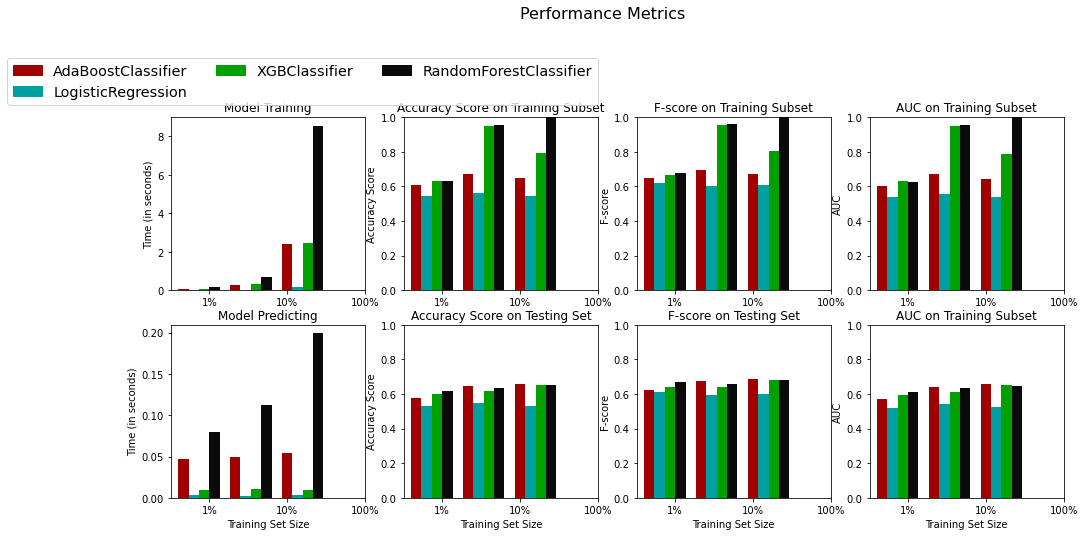

In [63]:
clf_A = AdaBoostClassifier(random_state=0)
clf_B = LogisticRegression(random_state=0,C=1.0)
clf_C = xgboost.XGBClassifier(eval_metric='mlogloss')
clf_D = RandomForestClassifier(random_state=0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(X_train_ga.shape[0]*0.01)
samples_10 = int(X_train_ga.shape[0]*0.1)
samples_100 = X_train_ga.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B,clf_C,clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train_ga, y_train_ga, X_test_ga, y_test_ga)
# Run metrics visualization for the three supervised learning models chosen
evaluate(results)